## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [2]:
import sqlite3
import pandas as pd
import requests
from bs4 import BeautifulSoup

I imported in a dataset provided by IMDB's interface. Scraping the data from their website turned out to be unnecessary.

This database is still missing the cost to make movie and the profit. We found a database containing the production costs, worldwide and domestic gross income. This information is not given to us in a file unfortunately like the previous dataset was, so we will have to employ some datascraping to pull this data off the website. We are grabbing our data from https://www.the-numbers.com/movie/budgets/all
I defined 2 functions to ease the load since I need to run a separate iteration of this script in order to catch the first page due to it having a unique url. 

In [85]:
'''Takes in the URL as an argument, and returns the chart that the movies are in.'''
def html_parse(url):
    html_page = requests.get(url, timeout=5)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    chart = soup.find(id = 'page_filling_chart')
    movie_container = chart.findAll('tr') #grabs all movie entries on the page and puts into a list
    return movie_container

In [86]:
'''Takes in the row containing the movie title, profits, release date, and costs and returns a list of those.'''
def movie_extract(data_container):
        release_date = data_container[1].text #release date
        movie_name = data_container[2].text #name of movie
        prod_budget = data_container[3].get_text(strip=True) #production budget
        gross_dom = data_container[4].get_text(strip=True) #gross domestic 
        gross_world = data_container[5].get_text(strip=True) #gross worldwide
        #we want to strip all of the newline junk off of the text.
        
        return [release_date, movie_name, prod_budget, gross_dom, gross_world]

This is the initial run of the function due to the URL being unique for the very first page.

In [87]:
df = pd.DataFrame(columns = ['Release_Date', 'Movie_Name', 'Production_Budget', 'Gross_Domestic', 'Gross_Worldwide'])
url = "https://www.the-numbers.com/movie/budgets/all"
movie_container = html_parse(url)

#for loop here to iterate through the list of movies in movie_container
for u in range(1,101):
    data_container = movie_container[u].findAll('td')

    data_series = movie_extract(data_container)
    
    a_series = pd.Series(data_series, index = df.columns)
    df = df.append(a_series, ignore_index=True)

Iterates through all the pages utilizing URL hacking to find all of the pages.

In [88]:
for i in range(2,61): #change 4 to 61 for all
    url = "https://www.the-numbers.com/movie/budgets/all/{}01".format(i)
    movie_container = html_parse(url)

    #for loop here to iterate through the list of movies in movie_container
    for u in range(1,101): 
        if i == 60 and u == 44:
            break
        data_container = movie_container[u].findAll('td') #the tag we want to look through

        data_series = movie_extract(data_container)
        
        a_series = pd.Series(data_series, index = df.columns)
        df = df.append(a_series, ignore_index=True)


In [90]:
df.to_csv('zippedData/movieMoney.csv') #saving it to a CSV so I don't have to scrape everytime I want to look at the data

In [4]:
df.head()

,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide
0,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,797,800,564"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,063,875","$1,045,663,875"
2,"Apr 22, 2015",Avengers: Age of Ultron,"$365,000,000","$459,005,868","$1,396,099,202"
3,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,065,478,084"
4,"Apr 25, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,359,754"
...,...,...,...,...,...
5938,Unknown,Red 11,"$7,000",$0,$0
5939,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5940,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5941,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


Putting in the datascrubbing + merging that was done by Simran around here I guess

# Believe these sections are unneeded now

Things we want to look at.
1) Day of release affects profit
2) Genre of movie affects profit
3) Actors in movie affects profit
4) Season of release affects profit
5) international sales
6) average number of movies to make
7) number of reviews and gross #scatter plot




1) Genre of movie affects profit
    a) season for the genre to be released
    boxplot
    b) What genres succeed internationally
    boxplot x- genres, y profit
2) Number of reviews and profit
    a)scatter plot, x is number of votes,y is profit #see if number of views is what matters
        i) color code the review rating, 10-8 green, 7-5 yellow etc...
    b) scatter plot, x is number of votes, y is production cost #see if higher production costs get more views
3) How does the number of movies created by a studio affect the average profit
    a)do franchises do better

Starting to look at and scrub the data. The first step is going to be converting the datatypes into a usable form. 

In [2]:
df = pd.read_csv('zippedData/movieMoney.csv', index_col=0)

In [58]:
df.dtypes

Release_Date         datetime64[ns]
Movie_Name                   string
Production_Budget             int32
Gross_Domestic                int32
Gross_Worldwide               int64
dtype: object

In [3]:
df['Movie_Name'] = df['Movie_Name'].astype('string')

df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce')

df['Production_Budget'] = df['Production_Budget'].str.replace('$', '')
df['Production_Budget'] = df['Production_Budget'].str.replace(',', '')
df['Production_Budget'] = df['Production_Budget'].astype(int)

df['Gross_Domestic'] = df['Gross_Domestic'].str.replace('$', '')
df['Gross_Domestic'] = df['Gross_Domestic'].str.replace(',', '')
df['Gross_Domestic'] = df['Gross_Domestic'].astype(int)

df['Gross_Worldwide'] = df['Gross_Worldwide'].str.replace('$', '')
df['Gross_Worldwide'] = df['Gross_Worldwide'].str.replace(',', '')
df['Gross_Worldwide'] = df['Gross_Worldwide'].astype('int64')

df.sort_values('Release_Date', inplace=True, ascending=False) #sort by release date, most recent on top
df.head()

,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide
1502,2022-12-16,Heaven and Hell,40000000,0,0
602,2021-01-15,355,75000000,0,0
108,2021-01-01,Moonfall,150000000,0,0
133,2020-12-23,Top Gun: Maverick,140000000,0,0
20,2020-11-12,No Time to Die,250000000,0,0


The second step is to remove the films from the dataframe that haven't happened yet. The next step is to count the number of films that have no budget or not profit to see if they can be removed from the dataset without any problems.

Here we are removing films based on time. We've decided that we're only going to look at recent movies, films created in 1980 and on, films that haven't come out yet, and also removing any films that came out this year as well, due to Coronavirus dramatically changing what the movie industry looks like. Movies will likely be back to "normal" by the time that we would finish with filming and editing a movie so we'll be able to use traditional data.

Alongside that, we'll be looking for any duplicates.

In [9]:
print(df[df.duplicated()]) #looking for any duplicated rows

,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide


In [25]:
df.head()

,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide
1502,2022-12-16,Heaven and Hell,40000000,0,0
602,2021-01-15,355,75000000,0,0
108,2021-01-01,Moonfall,150000000,0,0
133,2020-12-23,Top Gun: Maverick,140000000,0,0
20,2020-11-12,No Time to Die,250000000,0,0


There doesn't seem to be any duplicated rows in our movie money dataframe.

In [26]:
df_filtered = df[(df['Release_Date'] < '2020-01-01') & (df['Release_Date'] > '1979-12-31')] 
print(df_filtered.head(), df_filtered.tail())

     Release_Date         Movie_Name  Production_Budget  Gross_Domestic  \
3640   2019-12-31         The Grudge           10000000        21216148   
2404   2019-12-27      The Gentlemen           22000000        36296854   
1293   2019-12-25       Little Women           42000000       108095955   
305    2019-12-25  Spies in Disguise          100000000        66757013   
287    2019-12-25               1917          100000000       159227644   

      Gross_Worldwide  
3640         49503265  
2404        111800189  
1293        209065465  
305         166083937  
287         358403321        Release_Date          Movie_Name  Production_Budget  Gross_Domestic  \
5332   1980-02-01             The Fog            1100000        21445318   
5680   1980-01-01              Maniac             350000        10000000   
4727   1980-01-01        Terror Train            3500000         8000000   
1713   1980-01-01  Lion of the Desert           35000000         1500000   
4166   1980-01-01     Dre

We're filtered down our money dataset to only contain the films that we are planning on looking at by date.

The next step is to go through the IMDB dataset to remove data that we don't have profit information for.

Here we are loading in the dataset that we will be comparing the dataframe we have money information from. We're going to go ahead and convert the datatypes to their usable forms while we're doing this. 

In [64]:
title_basics_df = pd.read_csv('zippedData/title.basics.tsv', sep='\t')
title_basics_list = list(title_basics_df.columns)
unwanted_col = ['isAdult', 'startYear', 'endYear', 'runtimeMinutes']
title_basics_list = [ele for ele in title_basics_list if ele not in unwanted_col] 
for col in title_basics_list:
    title_basics_df[col] = title_basics_df[col].astype('string')
title_basics_df.drop(title_basics_df[title_basics_df['titleType'] != 'movie'].index, inplace=True) #drop any rows that aren't movies
title_basics_df['startYear'] = pd.to_datetime(title_basics_df['startYear'], format='%Y/%m/%d', errors='coerce')
title_basics_df['startYear'].dropna
title_basics_df['endYear'] = pd.to_datetime(title_basics_df['endYear'], format='%Y/%m/%d', errors='coerce') #coerces the faulty datetimes, we'll fix them later
title_basics_df['runtimeMinutes'].replace(to_replace='\\N', value='0', inplace=True)
title_basics_df['runtimeMinutes'] = title_basics_df['runtimeMinutes'].astype('int', errors='ignore')

In [65]:
movie_list = list(df_filtered['Movie_Name'].unique()) #create a list of the movie titles we have money information for
title_basics_df.drop(title_basics_df[title_basics_df['titleType'] != 'movie'].index, inplace=True) #drop any rows that are not movies
title_basics_df = title_basics_df[title_basics_df['primaryTitle'].isin(movie_list)] #only keep movies we have money information for
title_basics_df_filt = title_basics_df[(title_basics_df['startYear'] < '2020-01-01') & (title_basics_df['startYear'] > '1979-12-31')] 
movie_list = list(title_basics_df_filt['tconst'].unique()) #making the new list of movie names with IMDB uid
title_basics_df_filt.to_csv('zippedData/title_basics_pared.csv')
print(title_basics_df_filt.head()) #preview what we got
title_basics_df = None #clear the variable for memory, was having memory issues and I have a lot of DF to go through

          tconst titleType    primaryTitle originalTitle  isAdult  startYear  \
73496  tt0075035     movie           Panic     Bakterion        0 1982-01-01   
76154  tt0077759     movie         Jackpot       Jackpot        0 1980-01-01   
76732  tt0078356     movie            Tusk          Tusk        0 1980-01-01   
77231  tt0078868     movie      Confidence       Bizalom        0 1980-01-01   
77288  tt0078926     movie  The Good Thief    Il ladrone        0 1980-01-01   

      endYear  runtimeMinutes         genres  
73496     NaT              90  Horror,Sci-Fi  
76154     NaT              84             \N  
76732     NaT             119          Drama  
77231     NaT             105          Drama  
77288     NaT             108         Comedy  


We now have a dataframe that only contains movies we have profit information for. We can now use the unique identifier for movies titles in IMDB's database to continue to pare down the remaining dataframes that we have. 

In [66]:
title_crew_df = pd.read_csv('zippedData/title.crew.tsv', sep='\t')
title_crew_df = title_crew_df[title_crew_df['tconst'].isin(movie_list)] #only keep movies we have money information for
title_crew_df.to_csv('zippedData/title_crew_pared.csv')
print(title_crew_df.head()) #preview what we got
title_crew_df = None

          tconst            directors  \
73496  tt0075035            nm0723260   
76154  tt0077759  nm0919103,nm1277309   
76732  tt0078356            nm0423524   
77231  tt0078868            nm0843640   
77288  tt0078926            nm0275269   

                                                 writers  
73496                                nm0146033,nm0173549  
76154                      nm0255196,nm1277309,nm0919103  
76732            nm0132798,nm0629947,nm0423524,nm0641530  
77231                                nm0843640,nm0844438  
77288  nm0275269,nm0315790,nm0420651,nm0817118,nm0879676  


In [67]:
title_akas_df = pd.read_csv('zippedData/title.akas.tsv', sep='\t')
title_akas_df = title_akas_df[title_akas_df['titleId'].isin(movie_list)] #only keep movies we have money information for
title_akas_df.to_csv('zippedData/title_akas_pared.csv')
print(title_akas_df.head()) #preview what we got
title_akas_df = None

D:\Python\anaconda37\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


          titleId  ordering             title region language        types  \
507118  tt0075035        10  Monster of Blood     US       \N          dvd   
507119  tt0075035        11         Bakterion     IT       \N  imdbDisplay   
507120  tt0075035        12          Paniikki     FI       \N        video   
507121  tt0075035        13         Bakterion     \N       \N     original   
507122  tt0075035        14            Pânico     BR       \N           \N   

       attributes isOriginalTitle  
507118         \N               0  
507119         \N               0  
507120         \N               0  
507121         \N               1  
507122         \N               0  


In [68]:
#title_principals_df = pd.read_csv('zippedData/title.principals.tsv', sep='\t')
iter_csv = pd.read_csv('zippedData/title.principals.tsv', sep='\t', iterator=True, chunksize=10000)
title_principals_df = pd.concat([chunk[chunk['tconst'].isin(movie_list)] for chunk in iter_csv])
title_principals_df.to_csv('zippedData/title_principals_pared.csv')
print(title_principals_df.head()) #preview what we got
title_principals_df = None

           tconst  ordering     nconst         category job  \
632161  tt0075035        10  nm0005653  cinematographer  \N   
632162  tt0075035         1  nm0911285            actor  \N   
632163  tt0075035         2  nm0013302          actress  \N   
632164  tt0075035         3  nm0723247            actor  \N   
632165  tt0075035         4  nm0509811            actor  \N   

                  characters  
632161                    \N  
632162      ["Captain Kirk"]  
632163        ["Jane Blake"]  
632164   ["Professor Adams"]  
632165  ["Sergeant O'Brien"]  


In [69]:
title_ratings_df = pd.read_csv('zippedData/title.ratings.tsv', sep='\t')
title_ratings_df = title_ratings_df[title_ratings_df['tconst'].isin(movie_list)] #only keep movies we have money information for
title_ratings_df.to_csv('zippedData/title_ratings_pared.csv')
print(title_ratings_df.head()) #preview what we got
title_ratings_df = None

          tconst  averageRating  numVotes
50555  tt0075035            3.3       557
53380  tt0078356            4.9       405
53825  tt0078868            7.6       582
53879  tt0078926            7.0       436
54736  tt0079938            8.1       645


In [70]:
name_basics_df = pd.read_csv('zippedData/name.basics.tsv', sep='\t')
name_basics_df['nconst'] = name_basics_df['nconst'].astype('string')
name_basics_df['primaryName'] = name_basics_df['primaryName'].astype('string')
name_basics_df['primaryProfession'] = name_basics_df['primaryProfession'].astype('string')
name_basics_df['knownForTitles'] = name_basics_df['knownForTitles'].astype('string')
name_basics_df['birthYear'] = pd.to_datetime(name_basics_df['birthYear'], errors='coerce')
name_basics_df['deathYear'] = pd.to_datetime(name_basics_df['deathYear'], errors='coerce')
name_basics_df.dtypes

nconst                       string
primaryName                  string
birthYear            datetime64[ns]
deathYear            datetime64[ns]
primaryProfession            string
knownForTitles               string
dtype: object

#to here

In [17]:
title_akas_df.drop(title_akas_df[title_akas_df['region'] != 'US'].index, inplace=True) #holding onto this code incase I want it

1) Genre of movie affects profit a) season for the genre to be released boxplot b) What genres succeed internationally boxplot x- genres, y profit

This is where we'll be making our genre graph. Will be coming back to this later. 

In [ ]:
sns.boxplot(x='genres', y='Profit', data=df)

In [ ]:
sns.boxplot(x='season', y='profit', hue='international?',
            col='genre', col_wrap=6, data=df)
#idk depends on the number of genres really

In [82]:
import seaborn as sns
%matplotlib inline

Our final dataset containing the movie budget information. 

In [102]:
df = pd.read_csv('Final_Data/Final_Movie_Budget.csv', index_col=0)


Making sure that our dateset only contains the movies that fall within the timeframe we're looking at. Should've been done earlier, but if anything was missed it'll be caught here. 

In [104]:
df['Release_Date'] = pd.to_datetime(df.Release_Date, errors='coerce') #convert into datetimes
df.sort_values(by='Release_Date') #sort by release date
df_filter = df.loc[(df['Release_Date'] < '2020-01-01') & (df['Release_Date'] > '1979-12-31')] #select the right dates


In [105]:
df_filter

,studio,year,Movie_title,tconst,runtimeMinutes,averageRating,numVotes,region,language,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide,_merge,Gross_Foreign_Only,Profit
0,NaN,1994.0,The Shawshank Redemption,tt0111161,142,9.3,2259481.0,60.0,60.0,1994-09-23,The Shawshank Redemption,25000000.0,28241469.0,2.841706e+07,both,175591.0,3417060.0
1,NaN,2008.0,The Dark Knight,tt0468569,152,9.0,2225006.0,59.0,59.0,2008-07-11,The Dark Knight,185000000.0,533720947.0,1.000743e+09,both,467021804.0,815742751.0
2,WB,2010.0,Inception,tt1375666,148,8.8,1982266.0,52.0,52.0,2010-07-16,NaN,160000000.0,292576195.0,8.355246e+08,left_only,535700000.0,675524642.0
3,NaN,1999.0,Fight Club,tt0137523,139,8.8,1794853.0,NaN,NaN,1999-10-15,Fight Club,65000000.0,37030102.0,1.008345e+08,both,63804388.0,35834490.0
4,NaN,1994.0,Pulp Fiction,tt0110912,154,8.9,1767823.0,51.0,51.0,1994-09-10,Pulp Fiction,8000000.0,107928762.0,2.129119e+08,both,104983148.0,204911910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-07-15,Embrace,225000.0,412340.0,1.611592e+06,right_only,1199252.0,1386592.0
8334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-08-29,Lunch Time Heroes,100000.0,0.0,0.000000e+00,right_only,0.0,-100000.0
8335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-08-28,Turbo Kid,60000.0,0.0,0.000000e+00,right_only,0.0,-60000.0
8336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-13,The VelociPastor,35000.0,0.0,0.000000e+00,right_only,0.0,-35000.0


In [77]:
genre_df = pd.read_csv('zippedData/title.basics.tsv', sep='\t')

D:\Python\anaconda37\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We're merging the genre data into the dataset that contains the rest of our information, including votes, money, and release dates. 

In [106]:
df_filter.merge(genre_df, how='inner', on='tconst')

,studio,year,Movie_title,tconst,runtimeMinutes_x,averageRating,numVotes,region,language,Release_Date,...,Gross_Foreign_Only,Profit,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes_y,genres
0,NaN,1994.0,The Shawshank Redemption,tt0111161,142,9.3,2259481.0,60.0,60.0,1994-09-23,...,175591.0,3417060.0,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,\N,142,Drama
1,NaN,2008.0,The Dark Knight,tt0468569,152,9.0,2225006.0,59.0,59.0,2008-07-11,...,467021804.0,815742751.0,movie,The Dark Knight,The Dark Knight,0,2008,\N,152,"Action,Crime,Drama"
2,WB,2010.0,Inception,tt1375666,148,8.8,1982266.0,52.0,52.0,2010-07-16,...,535700000.0,675524642.0,movie,Inception,Inception,0,2010,\N,148,"Action,Adventure,Sci-Fi"
3,NaN,1999.0,Fight Club,tt0137523,139,8.8,1794853.0,NaN,NaN,1999-10-15,...,63804388.0,35834490.0,movie,Fight Club,Fight Club,0,1999,\N,139,Drama
4,NaN,1994.0,Pulp Fiction,tt0110912,154,8.9,1767823.0,51.0,51.0,1994-09-10,...,104983148.0,204911910.0,movie,Pulp Fiction,Pulp Fiction,0,1994,\N,154,"Crime,Drama"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4854,NaN,1997.0,Kama Sutra,tt7881924,\N,NaN,NaN,1.0,1.0,1997-02-28,...,0.0,1109095.0,movie,Kama Sutra,Kama Sutra,0,2002,\N,\N,Drama
4855,NaN,2017.0,Sky Sharks,tt3977848,110,NaN,NaN,4.0,4.0,2017-09-01,...,0.0,-2500000.0,movie,Sky Sharks,Sky Sharks,0,2020,\N,110,"Comedy,Horror,Sci-Fi"
4856,NaN,2007.0,Sublime,tt9893078,93,NaN,NaN,3.0,3.0,2007-03-13,...,0.0,-1800000.0,movie,Sublime,Sublime,0,2019,\N,93,"Biography,Documentary,Music"
4857,NaN,2014.0,40 Weeks,tt3513086,111,NaN,NaN,3.0,3.0,2014-12-02,...,0.0,-900000.0,movie,40 Weeks,40 Weeks,0,2014,\N,111,Documentary


In [103]:
df['Profit'] = df['Gross_Worldwide'] - df['Production_Budget'] #create the profit column

We are looking at if the number of votes is related to the amount of money that is made by the film.

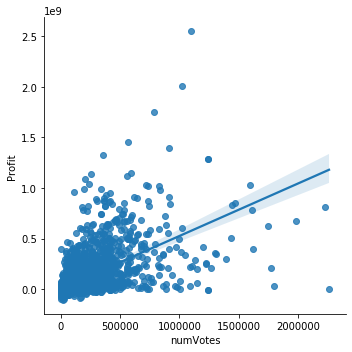

In [107]:
sns.lmplot(x='numVotes', y='Profit', data=df_filter)

Here we are going to be looking at if there is a relationship between how much money is spent on a film and if more money spent on the film results in more votes, which we've assumed to mean more views.

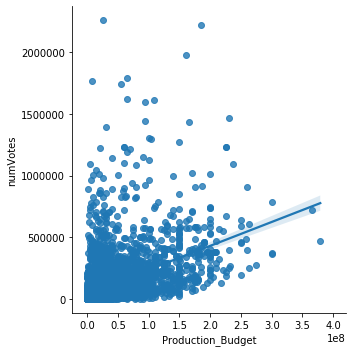

In [108]:
sns.lmplot(y='numVotes', x='Production_Budget', data=df_filter)


3) How does the number of movies created by a studio affect the average profit a)do franchises do better

In [110]:
df_filter.sort_values(by=['Release_Date', 'studio'])

,studio,year,Movie_title,tconst,runtimeMinutes,averageRating,numVotes,region,language,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide,_merge,Gross_Foreign_Only,Profit
3096,NaN,1980.0,Maniac,tt2103217,89,6.1,34321.0,17.0,17.0,1980-01-01,Maniac,350000.0,10000000.0,10000000.0,both,0.0,9650000.0
3114,NaN,1980.0,Dressed to Kill,tt0080661,104,7.1,33579.0,31.0,31.0,1980-01-01,Dressed to Kill,6500000.0,31899000.0,31899000.0,both,0.0,25399000.0
4159,NaN,1980.0,Lion of the Desert,tt0081059,173,8.4,13529.0,30.0,30.0,1980-01-01,Lion of the Desert,35000000.0,1500000.0,1500000.0,both,0.0,-33500000.0
4554,NaN,1980.0,Terror Train,tt0081617,97,5.9,9410.0,31.0,31.0,1980-01-01,Terror Train,3500000.0,8000000.0,8000000.0,both,0.0,4500000.0
2282,NaN,1980.0,The Fog,tt0080749,89,6.8,61621.0,56.0,56.0,1980-02-01,The Fog,1100000.0,21445318.0,21445820.0,both,502.0,20345820.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-25,1917,100000000.0,159227644.0,358403321.0,right_only,199175677.0,258403321.0
8104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-25,Spies in Disguise,100000000.0,66757013.0,166083937.0,right_only,99326924.0,66083937.0
8157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-25,Just Mercy,25000000.0,36001502.0,50401502.0,right_only,14400000.0,25401502.0
8161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-27,The Gentlemen,22000000.0,36296854.0,111800189.0,right_only,75503335.0,89800189.0


Here we are going to group our films by what year they came out, and by what studio created them. We're looking at the number of films released by a studio that year, how much money it made, and alongside that, the costs to create it.

In [119]:
studio_df = df_filter.groupby(['year', 'studio']).agg({'Movie_title' : 'count', 
                                               'numVotes' : 'mean',
                                               'Production_Budget' : 'mean',
                                               'Gross_Domestic' : 'mean',
                                               'Gross_Worldwide' : 'mean',
                                               'Profit' : 'mean'})

In [112]:
studio_df.head()

Movie_title       numVotes  Production_Budget  Gross_Domestic  \
year   studio                                                                  
2010.0 3D                1            NaN       5.000000e+06    6.096582e+06   
       ATO               1   16548.000000       1.250000e+07    2.039869e+06   
       Anch.             5   35920.000000       5.250000e+06    2.280092e+06   
       App.              1   45497.000000       9.500000e+06    3.573673e+06   
       BV                7  205876.714286       1.107143e+08    1.209646e+08   

               Gross_Worldwide        Profit  
year   studio                                 
2010.0 3D         1.651520e+07  1.151520e+07  
       ATO        2.272186e+06 -1.022781e+07  
       Anch.      3.579914e+06 -1.670086e+06  
       App.       5.278632e+06 -4.221368e+06  
       BV         3.064678e+08  1.957535e+08

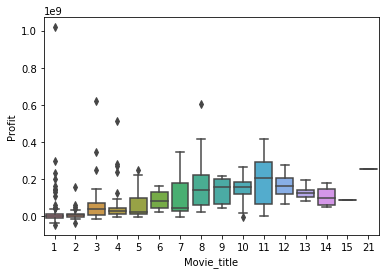

In [113]:
sns.boxplot(x='Movie_title', y='Profit', data=studio_df)

Looks like the best amount of movies to release in a year around 12. Least amount of variance. 